In [59]:
# Import the libraries.

import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

In [30]:
cm = ['#116FA1', '#2DC0D2', '#E0B266', '#00979F', '#70CAC6', '#005A7D']
bg = '#F9F9F9'

In [3]:
# Define the sample period.
START_DATE = '2019-01-01'
END_DATE = '2019-07-31'

#### Simulation of Stock Price Dynamics via Geometric Brownian Motion

In [25]:
# Download data from Yahoo Finance.
ticker = 'MSFT'
df = yf.download(ticker, start=START_DATE, end=END_DATE, auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


Sample average of returns: 0.242%


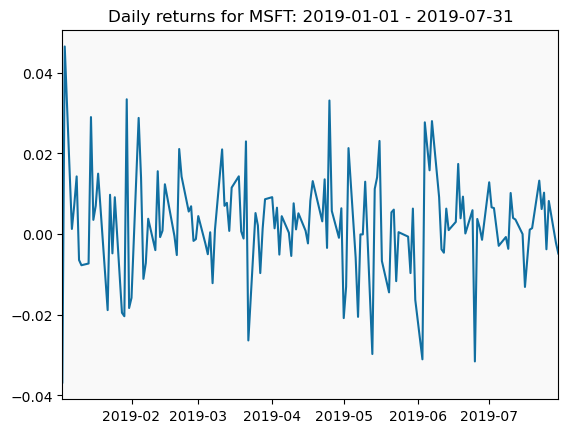

In [39]:
# Calculate daily returns.

adj_close = df.Close.MSFT
returns = adj_close.pct_change().dropna()

print(f'Sample average of returns: {100 * returns.mean():.3f}%')

# Plot the time series of returns.
fig, ax = plt.subplots()

ax.plot(returns, color=cm[0])

ax.set_title(f'Daily returns for {ticker}: {START_DATE} - {END_DATE}')
ax.set_facecolor(bg)
ax.set_xmargin(0.)

plt.show()

In [57]:
# Split data into the training and test sets.

train = returns[:'2019-06-30']
test = returns['2019-07-01':]

# Specify the parameters for the simulation.
T = len(test)                    # length of the forecast horizon
N = len(test)                    # number of time increments in the forecast horizon
S_0 = adj_close[train.index[-1]] # initial stock price
n_sims = 100                     # number of simulation paths
μ = train.mean()                 # drift coefficient
σ = train.std()                  # diffusion coefficient

In [60]:
# Define the function used for simulations.
def simulate_gbm(s_0, μ, σ, n_sims, T, N, random_seed=42):
    """ 
    Function used for simulating stock returns using Geometric Brownian Motion.
    """

    # Set random seed for replications.
    np.random.seed(random_seed)

    dt = T / N
    dW = np.random.normal(scale=np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)

    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, shape=(n_sims, N))

    S_t = s_0 * np.exp((μ - 0.5 * σ ** 2) * time_steps + σ * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)

    return S_t

In [70]:
# Run simulations and store the result in a DataFrame.
gbm_simulations = simulate_gbm(S_0, μ, σ, n_sims, T, N)
sim_df = pd.DataFrame(gbm_simulations.T, index=train.index[-1:].union(test.index))

sim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-28,127.017792,127.017792,127.017792,127.017792,127.017792,127.017792,127.017792,127.017792,127.017792,127.017792,...,127.017792,127.017792,127.017792,127.017792,127.017792,127.017792,127.017792,127.017792,127.017792,127.017792
2019-07-01,128.194456,126.920168,127.113584,125.228486,125.901637,128.030310,125.585123,125.013525,126.885755,124.677955,...,128.282353,131.306299,126.500493,126.171285,127.284081,129.214952,126.852202,126.424160,127.780076,126.526945
2019-07-02,128.251024,127.338002,126.883660,126.941694,125.325709,131.722924,124.899132,126.215642,125.866022,124.202460,...,128.595972,132.781933,126.612875,125.431154,126.900371,129.471861,123.676319,126.677179,128.424400,126.825935
2019-07-03,129.709606,125.148081,124.608866,129.649395,127.221090,132.352332,125.365985,127.033563,124.620299,125.978032,...,128.123478,134.019650,131.637380,128.138874,129.191861,128.203993,125.061653,123.907283,130.250420,128.185897
2019-07-05,132.782221,124.502198,123.665373,129.825484,128.101781,133.137405,124.789542,127.774617,123.512716,126.649170,...,128.230810,131.031248,129.233666,124.703288,131.203978,128.216585,123.226527,123.011840,130.309502,125.948116


In [72]:
# Create a DataFrame with the average value for each time step and the corresponding actual stock price.
res_df = sim_df.mean(axis=1).to_frame()
res_df = res_df.join(df.Close.MSFT)
res_df.columns = ['simulation_average', 'adj_close_price']

res_df.head()

,simulation_average,adj_close_price
Date,,
2019-06-28,127.017792,127.017792
2019-07-01,127.654197,128.648666
2019-07-02,127.863216,129.501984
2019-07-03,128.209421,130.336426
2019-07-05,128.587265,129.957153


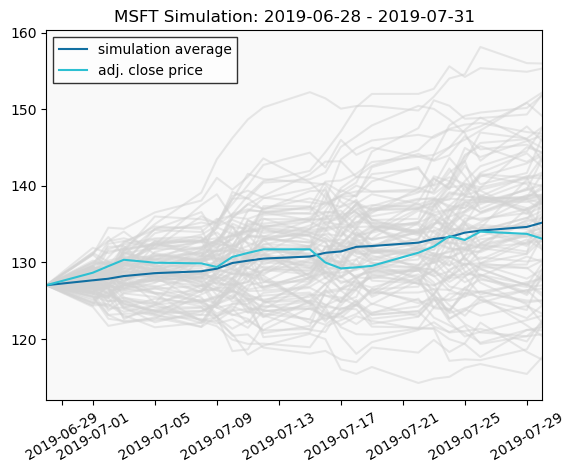

In [103]:
# Plot the results of the simulation.
fig, ax = plt.subplots()

ax.plot(sim_df, alpha=0.5, color='lightgray')
ax.plot(res_df.simulation_average, color=cm[0], label='simulation average')
ax.plot(res_df.adj_close_price, color=cm[1], label='adj. close price')

ax.legend(fancybox=False, edgecolor='k')
ax.set_title(f'{ticker} Simulation: {train.index[-1].date()} - {END_DATE}')
ax.set_facecolor(bg)
ax.set_xmargin(0)
plt.xticks(rotation=30)

plt.show()